Лабораторная работа 5

Исследование градиентного бустинга на задачах классификации Phishing Websites и регрессии Combined Cycle Power Plant

Импортируем библиотеки для работы с данными моделями градиентного бустинга и визуализацией

In [14]:
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    mean_absolute_error,
    r2_score
)
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

RANDOM_STATE = 15557

Задаем вспомогательные функции для регрессионных метрик и отрисовки матрицы ошибок чтобы не дублировать код

In [2]:
def regression_metrics_map(y_true, y_pred):
    rmse = float(np.sqrt(np.mean((y_true - y_pred) ** 2)))
    mae = float(mean_absolute_error(y_true, y_pred))
    r2 = float(r2_score(y_true, y_pred))
    return {"RMSE": rmse, "MAE": mae, "R2": r2}


def plot_confusion(cm, title, labels=None):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Purples")
    plt.title(title)
    plt.tight_layout()
    plt.show()

Готовим тренировочные и тестовые выборки для фишинговых сайтов и энергетического датасета CCPP как и в прошлых работах

In [3]:
# Классификация Phishing Websites
ds = fetch_openml(data_id=4534, as_frame=True)
df = ds.frame.copy()

y_cls = (df['Result'].astype(int) == 1).astype(int).to_numpy()
X_cls = df.drop(columns=['Result']).replace('?', np.nan).apply(pd.to_numeric, errors='coerce')

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cls,
    y_cls,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_cls
)

print('Баланс train:', np.unique(yc_train, return_counts=True))
print('Баланс test :', np.unique(yc_test, return_counts=True))

# Регрессия CCPP из локального файла
reg_path = '../datasets/Folds5x2_pp.xlsx'
try:
    df_reg = pd.read_excel(reg_path)
except FileNotFoundError:
    raise FileNotFoundError('Поместите рядом файл Folds5x2_pp.xlsx')

y_reg = df_reg['PE'].to_numpy()
X_reg = df_reg.drop(columns=['PE'])

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg,
    y_reg,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print('Размеры регрессии:', Xr_train.shape, Xr_test.shape)

Баланс train: (array([0, 1]), array([3918, 4926], dtype=int64))
Баланс test : (array([0, 1]), array([ 980, 1231], dtype=int64))
Размеры регрессии: (7654, 4) (1914, 4)


Строим простые модели градиентного бустинга без подбора гиперпараметров и фиксируем базовые метрики

Baseline classification: {'Accuracy': 0.952962460425147, 'MacroF1': 0.952287361454403, 'ROC-AUC': 0.9920779522206934}


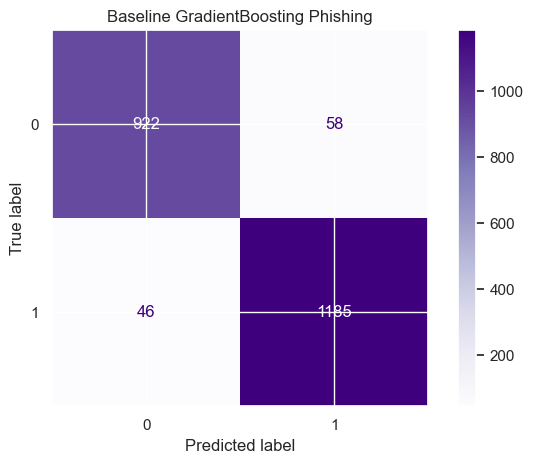

Baseline regression: {'RMSE': 3.8290563339742554, 'MAE': 2.9488059577352925, 'R2': 0.949452614910889}


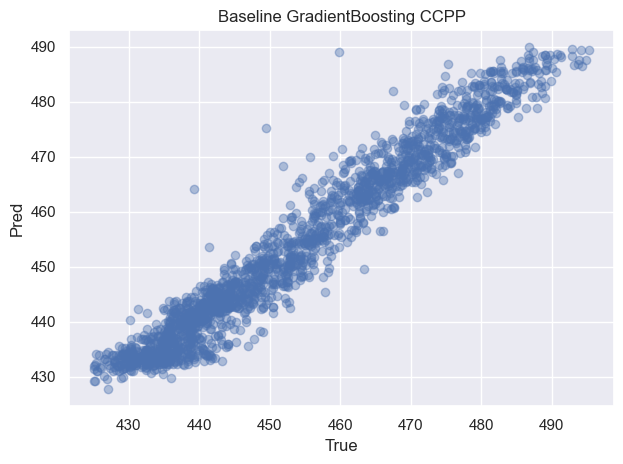

In [15]:
# Бейзлайн GradientBoosting для классификации
pipe_gb_c = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE))
])

pipe_gb_c.fit(Xc_train, yc_train)
yc0 = pipe_gb_c.predict(Xc_test)
yc0_proba = pipe_gb_c.predict_proba(Xc_test)[:, 1]

base_cls = {
    'Accuracy': accuracy_score(yc_test, yc0),
    'MacroF1': f1_score(yc_test, yc0, average='macro'),
    'ROC-AUC': roc_auc_score(yc_test, yc0_proba)
}
print('Baseline classification:', base_cls)

cm0 = confusion_matrix(yc_test, yc0, labels=[0, 1])
plot_confusion(cm0, 'Baseline GradientBoosting Phishing', labels=[0, 1])

# Бейзлайн GradientBoosting для регрессии
pipe_gb_r = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('gb', GradientBoostingRegressor(random_state=RANDOM_STATE))
])

pipe_gb_r.fit(Xr_train, yr_train)
yr0 = pipe_gb_r.predict(Xr_test)
base_reg = regression_metrics_map(yr_test, yr0)
print('Baseline regression:', base_reg)

plt.figure()
plt.scatter(yr_test, yr0, alpha=0.4)
plt.xlabel('True')
plt.ylabel('Pred')
plt.title('Baseline GradientBoosting CCPP')
plt.tight_layout()
plt.show()

Пробуем подкрутить количество деревьев глубину и скорость обучения через RandomizedSearchCV чтобы выжать из бустинга побольше качества

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Improved classification: {'Accuracy': 0.9760289461781999, 'MacroF1': 0.9756438936597802, 'ROC-AUC': 0.9973822510320132}
Best params (cls): {'gb__subsample': 0.9, 'gb__n_estimators': 500, 'gb__min_samples_leaf': 10, 'gb__max_depth': 5, 'gb__learning_rate': 0.07}


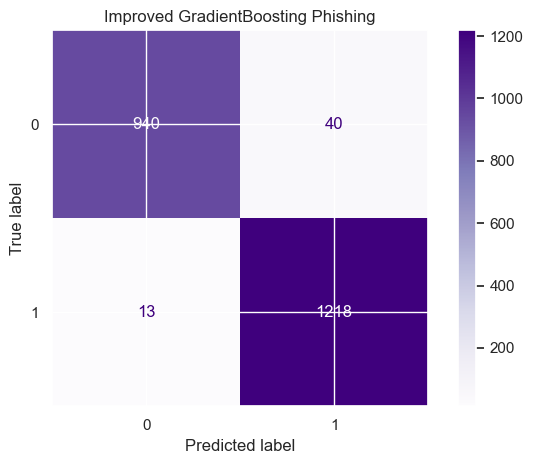

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Improved regression: {'RMSE': 2.9162698571754544, 'MAE': 2.085855089427332, 'R2': 0.9706795521279243}
Best params (reg): {'gb__subsample': 0.9, 'gb__n_estimators': 900, 'gb__min_samples_leaf': 10, 'gb__max_depth': 9, 'gb__learning_rate': 0.05}


In [26]:
# Улучшение GradientBoosting для классификации
cv_c = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

param_dist_c = {
    "gb__n_estimators": [200, 300, 400, 500, 600, 700, 900],
    "gb__learning_rate": [0.01, 0.03, 0.05, 0.07, 0.09],
    "gb__max_depth": [2, 3, 5, 7, 13, 16, 20],
    "gb__min_samples_leaf": [10, 20],
    "gb__subsample": [0.7, 0.9],
}

rs_gb_c = RandomizedSearchCV(
    estimator=pipe_gb_c,
    param_distributions=param_dist_c,
    n_iter=100,
    scoring='f1_macro',
    n_jobs=-1,
    cv=cv_c,
    random_state=RANDOM_STATE,
    refit=True,
    verbose=1
)

rs_gb_c.fit(Xc_train, yc_train)

yc1 = rs_gb_c.predict(Xc_test)
yc1_proba = rs_gb_c.predict_proba(Xc_test)[:, 1]

imp_cls = {
    'Accuracy': accuracy_score(yc_test, yc1),
    'MacroF1': f1_score(yc_test, yc1, average='macro'),
    'ROC-AUC': roc_auc_score(yc_test, yc1_proba)
}
print('Improved classification:', imp_cls)
print('Best params (cls):', rs_gb_c.best_params_)

cm1 = confusion_matrix(yc_test, yc1, labels=[0, 1])
plot_confusion(cm1, 'Improved GradientBoosting Phishing', labels=[0, 1])

# Улучшение GradientBoosting для регрессии
cv_r = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

param_dist_r = {
    "gb__n_estimators": [50, 80, 100, 150, 200, 400, 500, 600, 700, 800, 850, 900, 1000],
    "gb__learning_rate": [0.03, 0.05],
    "gb__max_depth": [2, 3, 5, 9, 13, 15, 19, 24],
    "gb__min_samples_leaf": [5, 10, 20, 25, 30],
    "gb__subsample": [0.6, 0.65, 0.7, 0.9, 0.95],
}

rs_gb_r = RandomizedSearchCV(
    estimator=pipe_gb_r,
    param_distributions=param_dist_r,
    n_iter=100,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=cv_r,
    random_state=RANDOM_STATE,
    refit=True,
    verbose=1
)

rs_gb_r.fit(Xr_train, yr_train)

yr1 = rs_gb_r.predict(Xr_test)
imp_reg = regression_metrics_map(yr_test, yr1)
print('Improved regression:', imp_reg)
print('Best params (reg):', rs_gb_r.best_params_)   

Сравниваем метрики базового и затюненного бустинга в небольших сводных таблицах

In [27]:
df_cls_cmp = pd.DataFrame([
    {'Model': 'Baseline GB', **base_cls},
    {'Model': 'Improved GB', **imp_cls}
])
print('Сравнение классификации GradientBoosting')
display(df_cls_cmp.round(4))

df_reg_cmp = pd.DataFrame([
    {'Model': 'Baseline GB', **base_reg},
    {'Model': 'Improved GB', **imp_reg}
])
print('Сравнение регрессии GradientBoosting')
display(df_reg_cmp.round(4))

Сравнение классификации GradientBoosting


,Model,Accuracy,MacroF1,ROC-AUC
0,Baseline GB,0.953,0.9523,0.9921
1,Improved GB,0.976,0.9756,0.9974


Сравнение регрессии GradientBoosting


,Model,RMSE,MAE,R2
0,Baseline GB,3.8291,2.9488,0.9495
1,Improved GB,2.9163,2.0859,0.9707


Делаем простую реализацию градиентного бустинга на деревьях чтобы лучше почувствовать принцип работы алгоритма

In [28]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))


class SimpleGBRegressor:
    def __init__(self, n_estimators=50, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees_ = []
        self.init_ = None

    def fit(self, X, y):
        n_samples = X.shape[0]
        self.init_ = np.mean(y)
        current_pred = np.full(n_samples, self.init_, dtype=float)
        self.trees_ = []
        rng = np.random.RandomState(self.random_state)
        for m in range(self.n_estimators):
            residual = y - current_pred
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=rng.randint(0, 10**6))
            tree.fit(X, residual)
            update = tree.predict(X)
            current_pred += self.learning_rate * update
            self.trees_.append(tree)
        return self

    def predict(self, X):
        y_pred = np.full(X.shape[0], self.init_, dtype=float)
        for tree in self.trees_:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred


class SimpleGBClassifier:
    def __init__(self, n_estimators=50, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state
        self.trees_ = []
        self.init_ = None

    def fit(self, X, y):
        n_samples = X.shape[0]
        p = np.clip(np.mean(y), 1e-5, 1 - 1e-5)
        self.init_ = np.log(p / (1 - p))
        f = np.full(n_samples, self.init_, dtype=float)
        self.trees_ = []
        rng = np.random.RandomState(self.random_state)
        for m in range(self.n_estimators):
            p_hat = sigmoid(f)
            residual = y - p_hat
            tree = DecisionTreeRegressor(max_depth=self.max_depth, random_state=rng.randint(0, 10**6))
            tree.fit(X, residual)
            update = tree.predict(X)
            f += self.learning_rate * update
            self.trees_.append(tree)
        return self

    def predict_proba(self, X):
        f = np.full(X.shape[0], self.init_, dtype=float)
        for tree in self.trees_:
            f += self.learning_rate * tree.predict(X)
        p1 = sigmoid(f)
        proba = np.vstack([1 - p1, p1]).T
        return proba

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)

Обучаем самописные версии бустинга на тех же данных и сравниваем их с sklearn реализациями

In [29]:
imp_c = SimpleImputer(strategy='most_frequent').fit(Xc_train)
Xs_c_tr = imp_c.transform(Xc_train)
Xs_c_te = imp_c.transform(Xc_test)

imp_r = SimpleImputer(strategy='median').fit(Xr_train)
Xs_r_tr = imp_r.transform(Xr_train)
Xs_r_te = imp_r.transform(Xr_test)

s_gb_c = SimpleGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE)
s_gb_c.fit(Xs_c_tr, yc_train)
ys_c = s_gb_c.predict(Xs_c_te)
ys_c_proba = s_gb_c.predict_proba(Xs_c_te)[:, 1]

scratch_cls = {
    'Accuracy': accuracy_score(yc_test, ys_c),
    'MacroF1': f1_score(yc_test, ys_c, average='macro'),
    'ROC-AUC': roc_auc_score(yc_test, ys_c_proba)
}
print('Scratch classification:', scratch_cls)

s_gb_r = SimpleGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE)
s_gb_r.fit(Xs_r_tr, yr_train)
ys_r = s_gb_r.predict(Xs_r_te)
scratch_reg = regression_metrics_map(yr_test, ys_r)
print('Scratch regression:', scratch_reg)

Scratch classification: {'Accuracy': 0.9194934418815016, 'MacroF1': 0.9183557381130196, 'ROC-AUC': 0.9749266400305044}
Scratch regression: {'RMSE': 3.947507904753972, 'MAE': 3.0655661460645263, 'R2': 0.9462768834601346}


Финально сравниваем три варианта градиентного бустинга по основным метрикам

In [30]:
df_cls_all = pd.DataFrame([
    {'Model': 'Baseline GB', **base_cls},
    {'Model': 'Improved GB', **imp_cls},
    {'Model': 'Scratch GB', **scratch_cls}
])
print('Классификация GradientBoosting')
display(df_cls_all.round(4))

df_reg_all = pd.DataFrame([
    {'Model': 'Baseline GB', **base_reg},
    {'Model': 'Improved GB', **imp_reg},
    {'Model': 'Scratch GB', **scratch_reg}
])
print('Регрессия GradientBoosting')
display(df_reg_all.round(4))

Классификация GradientBoosting


,Model,Accuracy,MacroF1,ROC-AUC
0,Baseline GB,0.9530,0.9523,0.9921
1,Improved GB,0.9760,0.9756,0.9974
2,Scratch GB,0.9195,0.9184,0.9749


Регрессия GradientBoosting


,Model,RMSE,MAE,R2
0,Baseline GB,3.8291,2.9488,0.9495
1,Improved GB,2.9163,2.0859,0.9707
2,Scratch GB,3.9475,3.0656,0.9463
